In [1]:
from platform import python_version
print(python_version())
from numba import cuda
cuda.select_device(0)
cuda.close()

3.7.10


A: The usage of the data set is unrestricted. But you should provide the link to our original download site, acknowledge the NIH Clinical Center and provide a citation to our CVPR 2017 paper

A: ‘No finding’ means the 14 listed disease patterns are not found in the image. 

https://www.kaggle.com/nih-chest-xrays/data

Citations
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

NIH News release: NIH Clinical Center provides one of the largest publicly available chest x-ray datasets to scientific community

Original source files and documents: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345

### Context Behind Dataset for Final Writeup:

Dataset was gathered by the NIH and contains over 100,000 anonymized chest x-ray images from more than 30,000 patients.  

# Goal
The goal is to use a simple model to classify x-ray images in Keras

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
import tensorflow

In [4]:
all_xray_df = pd.read_csv('../data/Data_Entry_2017.csv')
folderlist = glob(os.path.join('../data', 'images*'))
imglist = []
for folder in folderlist:
    tmp = glob(os.path.join(folder, "images", "*.png"))
    imglist += tmp
all_image_paths = {os.path.basename(x): x for x in imglist}
#{k:all_image_paths[k] for k in all_image_paths.keys()[:5]}
list(all_image_paths.items())[:4]
# all_image_paths = {os.path.basename(x): x for x in 
#                    glob(os.path.join('.', 'data', 'images*', '*.png'))}



[('00018942_001.png', '../data/images_009/images/00018942_001.png'),
 ('00020323_001.png', '../data/images_009/images/00020323_001.png'),
 ('00018730_001.png', '../data/images_009/images/00018730_001.png'),
 ('00019551_000.png', '../data/images_009/images/00019551_000.png')]

In [5]:
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
num_selected = 10000
tmp = {key: all_image_paths[key] for key in sorted(list(all_image_paths.keys()))[num_selected:]}
print(list(tmp.items())[:4])
all_xray_df['path'] = all_xray_df['Image Index'][num_selected:].map(tmp.get)
all_xray_df = all_xray_df[num_selected:]
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120
[('00002587_005.png', '../data/images_002/images/00002587_005.png'), ('00002588_000.png', '../data/images_002/images/00002588_000.png'), ('00002589_000.png', '../data/images_002/images/00002589_000.png'), ('00002589_001.png', '../data/images_002/images/00002589_001.png')]


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
55749,00013950_007.png,Atelectasis|Infiltration,7,13950,65,M,AP,2500,2048,0.168,0.168,NaN,../data/images_007/images/00013950_007.png
81336,00019978_001.png,Atelectasis|Pneumonia,1,19978,51,F,PA,2854,2991,0.143,0.143,NaN,../data/images_009/images/00019978_001.png
103875,00027725_049.png,Atelectasis|Infiltration,49,27725,21,M,AP,3056,2544,0.139,0.139,NaN,../data/images_011/images/00027725_049.png


In [6]:
label_counts = all_xray_df['Finding Labels'].value_counts()
label_counts

No Finding                                                                 54652
Infiltration                                                                8734
Atelectasis                                                                 3848
Effusion                                                                    3659
Nodule                                                                      2495
Mass                                                                        2015
Pneumothorax                                                                1972
Effusion|Infiltration                                                       1511
Atelectasis|Infiltration                                                    1237
Consolidation                                                               1199
Atelectasis|Effusion                                                        1091
Pleural_Thickening                                                          1004
Cardiomegaly                

# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

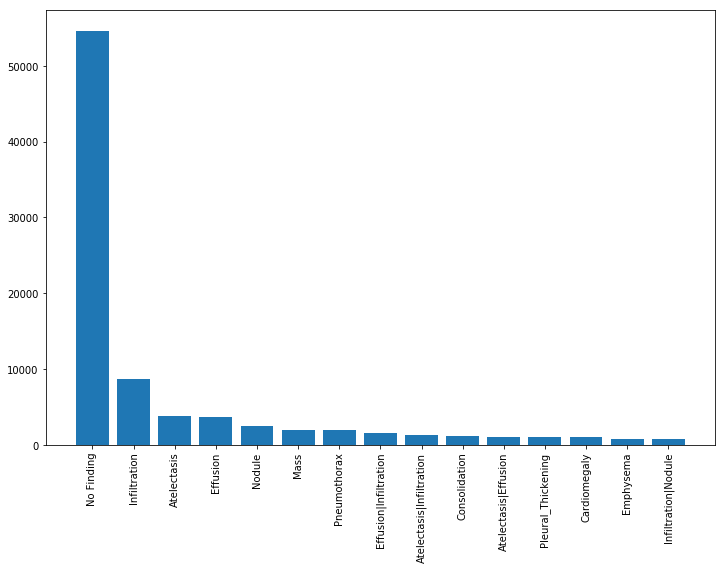

In [7]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [8]:
n_priorities = 4
priority1=['Pneumothorax']
priority2=['Pneumonia','Edema']
priority3=['Atelectasis','Cardiomegaly','Consolidation','Effusion','Emphysema','Fibrosis','Infiltration','Mass','Nodule','Pleural_Thickening']
priority4=['No Finding']

In [9]:
def priority_val(x):
    if any(item in priority1 for item in x):
        return 'priority1'
    elif any(item in priority2 for item in x):
        return 'priority2'
    elif any(item in priority3 for item in x):
        return 'priority3'
    elif any(item in priority4 for item in x):
        return 'priority4'
    
    

In [10]:
from itertools import chain
all_xray_df['Priority Label']=all_xray_df['Finding Labels'].map(lambda x: priority_val(x.split('|')))
all_xray_df['Priority Label'].sample(3)

65916     priority4
109185    priority4
110737    priority4
Name: Priority Label, dtype: object

In [11]:
#all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
31440,00008221_000.png,No Finding,0,8221,43,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
98335,00025972_000.png,Infiltration,0,25972,39,M,PA,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
107434,00029011_000.png,No Finding,0,29011,25,M,PA,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [12]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

### Clean categories
Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [13]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (14) [('Atelectasis', 10670), ('Cardiomegaly', 2476), ('Consolidation', 4271), ('Edema', 2150), ('Effusion', 12410), ('Emphysema', 2295), ('Fibrosis', 1407), ('Infiltration', 18291), ('Mass', 5454), ('No Finding', 54652), ('Nodule', 5887), ('Pleural_Thickening', 3060), ('Pneumonia', 1296), ('Pneumothorax', 4862)]


In [14]:

res = [i for i, val in enumerate(list(all_xray_df['Priority Label'])) if val == None]


In [15]:
all_xray_df['Priority Label']
res = [i for i, val in enumerate(list(all_xray_df['Priority Label'])) if val == None]
print(res)

[1589, 1590, 1591, 1592, 2428, 2525, 5023, 5024, 5579, 6034, 9541, 9590, 11551, 12815, 13240, 14244, 14781, 15532, 15536, 16160, 18209, 19618, 20263, 20280, 20754, 22253, 22528, 23133, 23135, 23137, 24265, 27971, 28351, 36105, 36669, 37468, 39653, 40594, 40972, 42639, 43035, 43038, 43043, 43048, 44689, 44822, 44823, 44824, 46170, 46797, 48269, 59434, 59781, 62160, 63688, 64700, 67454, 67543, 67544, 70765, 73006, 74376, 74874, 74875, 74876, 74877, 76994, 77002, 77003, 78462, 78588, 78821, 81356, 84724, 84734, 84878, 87051, 90738, 90847, 92747, 93654, 95367, 97271, 97273, 97276, 97927, 98497, 99616]


In [16]:
res = [i for i, val in enumerate(list(all_xray_df['Priority Label'])) if val == None]
res
rows=all_xray_df.index[res]
all_xray_df=all_xray_df.drop(rows)

In [17]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
105413,00028328_000.png,No Finding,0,28328,29,M,PA,3044,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
23959,00006304_043.png,Infiltration,43,6304,67,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
68755,00016971_031.png,Mass|Nodule,31,16971,65,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [18]:
np.unique(list(all_xray_df['Priority Label']))

array(['priority1', 'priority2', 'priority3', 'priority4'], dtype='<U9')

In [19]:
all_priorities = np.unique(all_xray_df['Priority Label'])
#all_priorities = [x for x in all_priorities if len(x)>0]
all_priorities

array(['priority1', 'priority2', 'priority3', 'priority4'], dtype=object)

In [20]:
print('All Priorities ({}): {}'.format(len(all_priorities), all_priorities))
for p_label in all_priorities:
    if len(p_label)>1: # leave out empty labels
        all_xray_df[p_label] = all_xray_df['Priority Label'].map(lambda finding: 1.0 if p_label in finding else 0)
all_xray_df.sample(3)

All Priorities (4): ['priority1' 'priority2' 'priority3' 'priority4']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,priority1,priority2,priority3,priority4
42155,00010836_001.png,No Finding,1,10836,27,F,AP,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
102939,00027441_012.png,Pneumothorax,12,27441,11,F,AP,2420,2388,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
69220,00017082_001.png,Infiltration,1,17082,63,M,PA,2946,2948,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
for c_label, s_count in zip(all_labels, np.mean(all_xray_df[all_labels].values,0)):
    print('%s: %f' % (c_label, s_count))
arrivals=np.array(np.mean(all_xray_df[all_labels].values,0))
arrivals=arrivals/arrivals.sum(axis=0,keepdims=True)
disease_priority=np.array([[0,0,1,0],[0,0,1,0],[0,0,1,0],[0,1,0,0],[0,0,1,0],
                  [0,0,1,0],[0,0,1,0],[0,0,1,0],[0,0,1,0],[0,0,0,1],
                  [0,0,1,0],[0,0,1,0],[0,1,0,0],[1,0,0,0]])
priority_cost=[1000,100,10,1]
priority_costs=[1000,100,10,1]
#print(disease_priority)
print(priority_cost)
costs=np.matmul(disease_priority,priority_cost)
print(arrivals)
priority_arrivals=np.array(np.mean(all_xray_df[all_priorities].values,0))
rho_s=0.95
print(priority_arrivals)

Atelectasis: 0.104575
Cardiomegaly: 0.024267
Consolidation: 0.041859
Edema: 0.021072
Effusion: 0.121629
Emphysema: 0.022493
Fibrosis: 0.013790
Infiltration: 0.179267
Mass: 0.053454
No Finding: 0.535636
Nodule: 0.057698
Pleural_Thickening: 0.029991
Pneumonia: 0.012702
Pneumothorax: 0.047652
[1000, 100, 10, 1]
[0.08259729 0.01916691 0.03306214 0.01664331 0.09606676 0.01776577
 0.01089169 0.14159203 0.04221983 0.42306531 0.04557172 0.02368769
 0.01003244 0.03763711]
[0.04765172 0.0300886  0.3866238  0.53563588]


In [22]:
priority_arrivals=priority_arrivals/priority_arrivals.sum(axis=0,keepdims=True)
priority_service=np.repeat(1/rho_s,n_priorities)
print(costs)
service=np.repeat(1/rho_s,len(all_labels))
print(service)
rho=arrivals/service
print(rho)
priority_rho = priority_arrivals/priority_service
print(priority_rho)
parameters=pd.DataFrame(np.column_stack((all_labels,np.mean(all_xray_df[all_labels].values,0),arrivals,service,costs,rho)))

[  10   10   10  100   10   10   10   10   10    1   10   10  100 1000]
[1.05263158 1.05263158 1.05263158 1.05263158 1.05263158 1.05263158
 1.05263158 1.05263158 1.05263158 1.05263158 1.05263158 1.05263158
 1.05263158 1.05263158]
[0.07846742 0.01820856 0.03140903 0.01581115 0.09126342 0.01687748
 0.01034711 0.13451243 0.04010884 0.40191205 0.04329313 0.02250331
 0.00953081 0.03575526]
[0.04526913 0.02858417 0.36729261 0.50885408]


In [23]:
costs=np.array(pd.to_numeric(pd.Series(parameters[4].values)))
arrivals=np.array(pd.to_numeric(pd.Series(parameters[2].values)))
service=np.array(pd.to_numeric(pd.Series(parameters[3].values)))
rho=np.array(pd.to_numeric(pd.Series(parameters[5].values)))

In [ ]:
parameters

,0,1,2,3,4,5
0,Atelectasis,0.10457503528304846,0.08259728597858819,1.0526315789473684,10,0.07846742167965878
1,Cardiomegaly,0.024266896659871414,0.019166905349857953,1.0526315789473684,10,0.018208560082365058
2,Consolidation,0.04185941665359887,0.03306213762085756,1.0526315789473684,10,0.03140903073981468
3,Edema,0.021071820605300298,0.016643314419303147,1.0526315789473684,100,0.015811148698337992
4,Effusion,0.12162850870315195,0.09606675904351258,1.0526315789473684,10,0.09126342109133696
5,Emphysema,0.022492943390308922,0.017765770508046848,1.0526315789473684,10,0.016877481982644507
6,Fibrosis,0.013789791437980242,0.010891694599050945,1.0526315789473684,10,0.010347109869098398
7,Infiltration,0.17926728869374314,0.14159202978766228,1.0526315789473684,10,0.13451242829827917
8,Mass,0.05345381840991062,0.042219831089711335,1.0526315789473684,10,0.040108839535225774
9,No Finding,0.5356358789399404,0.4230653114622119,1.0526315789473684,1,0.4019120458891013


In [ ]:
print(all_xray_df[all_labels].sum())
print(all_xray_df[all_priorities].sum())

Atelectasis           10670.0
Cardiomegaly           2476.0
Consolidation          4271.0
Edema                  2150.0
Effusion              12410.0
Emphysema              2295.0
Fibrosis               1407.0
Infiltration          18291.0
Mass                   5454.0
No Finding            54652.0
Nodule                 5887.0
Pleural_Thickening     3060.0
Pneumonia              1296.0
Pneumothorax           4862.0
dtype: float64
priority1     4862.0
priority2     3070.0
priority3    39448.0
priority4    54652.0
dtype: float64


In [ ]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
all_xray_df['priority_vec'] = all_xray_df.apply(lambda x: [x[all_priorities].values], 1).map(lambda x: x[0])

In [ ]:
print(all_xray_df['disease_vec'].sample(3))
print(all_xray_df['priority_vec'].sample(3))

33803    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
86175    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
86579    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
Name: disease_vec, dtype: object
19942    [0.0, 0.0, 0.0, 1.0]
85779    [0.0, 0.0, 0.0, 1.0]
69069    [0.0, 0.0, 1.0, 0.0]
Name: priority_vec, dtype: object


In [ ]:
import random
random.seed(100)
optimal_cut_off=[0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5]
thresholds_accuracy=optimal_cut_off

In [ ]:
df=all_xray_df
from sklearn.model_selection import train_test_split
valid_df, test_df = train_test_split(df, 
                                   test_size = 0.5, 
                                   random_state = 2018,
                                   stratify = df['Priority Label'])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revie

In [ ]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
valid_df['newLabelP'] = valid_df['Priority Label']
print(valid_df.sample(3))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


            Image Index              Finding Labels  Follow-up #  Patient ID  \
39554  00010352_002.png                  No Finding            2       10352   
35298  00009321_014.png  Consolidation|Infiltration           14        9321   
22813  00006030_006.png                  No Finding            6        6030   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
39554           31              M            AP                 2500     2048   
35298           46              F            AP                 2500     2048   
22813           48              F            PA                 2990     2991   

       OriginalImagePixelSpacing[x  ...  Pneumonia  Pneumothorax priority1  \
39554                        0.168  ...        0.0           0.0       0.0   
35298                        0.168  ...        0.0           0.0       0.0   
22813                        0.143  ...        0.0           0.0       0.0   

      priority2  priority3  priority4  \


In [ ]:
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
test_df['newLabelP'] = test_df['Priority Label']
print(test_df.sample(3))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


            Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
97250  00025655_001.png       Effusion            1       25655           70   
89381  00022192_007.png      Emphysema            7       22192           73   
39606  00010352_054.png     No Finding           54       10352           32   

      Patient Gender View Position  OriginalImage[Width  Height]  \
97250              F            PA                 2992     2991   
89381              M            PA                 2992     2991   
39606              M            AP                 2048     2500   

       OriginalImagePixelSpacing[x  ...  Pneumonia  Pneumothorax priority1  \
97250                        0.143  ...        0.0           0.0       0.0   
89381                        0.143  ...        0.0           0.0       0.0   
39606                        0.168  ...        0.0           0.0       0.0   

      priority2  priority3  priority4  \
97250       0.0        1.0        0.0   
89381      

In [ ]:
import tensorflow as tf
def queue_wait_cost(pmat,costs,arrivals,service):
    clambda = costs*arrivals
    rho = arrivals/service
    clambda_pmat = np.matmul(clambda,pmat)
    rho_pmat = np.matmul(rho,pmat)
    vec1=1-np.cumsum(rho_pmat)
    vec2=np.roll(1-np.cumsum(rho_pmat),1)
    vec2[0]=1
    denom = (1/vec1)*(1/vec2)
    return sum(clambda_pmat*denom)
def queue_wait_cost_priority(pmat,priority_costs,priority_arrivals,priority_service):
    clambda = priority_costs*priority_arrivals
    rho = priority_arrivals/priority_service
    clambda_pmat = np.matmul(clambda,pmat)
    rho_pmat = np.matmul(rho,pmat)
    vec1=1-np.cumsum(rho_pmat)
    vec2=np.roll(1-np.cumsum(rho_pmat),1)
    vec2[0]=1
    denom = (1/vec1)*(1/vec2)
    return sum(clambda_pmat*denom)
def queue_loss(y_true,y_pred):
    y_pred = y_pred/y_pred.sum(axis=1,keepdims=True)
    pmat = np.matmul(np.transpose(y_true),y_pred)
    pmat = pmat/pmat.sum(axis=1,keepdims=True)
    clambda = costs*arrivals
    rho = arrivals/service
    clambda_pmat = np.matmul(clambda,pmat)
    rho_pmat = np.matmul(rho,pmat)
    vec1=1-np.cumsum(rho_pmat)
    vec2=np.roll(1-np.cumsum(rho_pmat),1)
    vec2[0]=1
    denom = (1/vec1)*(1/vec2)
    return sum(clambda_pmat*denom)

def queue_loss_tensor(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    #y_pred = tf.divide(y_pred,tf.reduce_sum(y_pred,axis=1,keepdims=True)+0.000000000001)
    pmat = tf.matmul(tf.transpose(y_true),y_pred)
    pmat = tf.divide(pmat,tf.reduce_sum(pmat,axis=1,keepdims=True)+0.000000000001)
    clambda = tf.reshape(tf.cast(tf.Variable(costs*arrivals),tf.float32),[1,14])
    rho = tf.reshape(tf.cast(tf.Variable(arrivals/service),tf.float32),[1,14])
    #print(rho.shape)
    clambda_pmat = tf.matmul(clambda,pmat)
    rho_pmat = tf.matmul(rho,pmat)
    vec1=1-tf.cumsum(rho_pmat,axis=1)
    #print(vec1)
    vec2=tf.roll(1-tf.cumsum(rho_pmat,axis=1),shift=1,axis=1)
    #print(vec2)
    vec2=tf.tensor_scatter_nd_update(vec2,indices=[[0,0]],updates=[1])
    #print(vec2)
    #print (tf.math.reciprocal(vec2))
    denom = tf.multiply(tf.math.reciprocal(vec1+0.00000000000001),tf.math.reciprocal(vec2+0.00000000000001))
    return tf.reshape(tf.reduce_sum(tf.multiply(clambda_pmat,denom)),[])
def queue_loss_tensor_priority(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    #y_pred = tf.divide(y_pred,tf.reduce_sum(y_pred,axis=1,keepdims=True)+0.000000000001)
    pmat = tf.matmul(tf.transpose(y_true),y_pred)
    pmat = tf.divide(pmat,tf.reduce_sum(pmat,axis=1,keepdims=True)+0.000000000001)
    clambda = tf.reshape(tf.cast(tf.Variable(priority_costs*priority_arrivals),tf.float32),[1,n_priorities])
    rho = tf.reshape(tf.cast(tf.Variable(priority_arrivals/priority_service),tf.float32),[1,n_priorities])
    #print(rho.shape)
    clambda_pmat = tf.matmul(clambda,pmat)
    rho_pmat = tf.matmul(rho,pmat)
    vec1=1-tf.cumsum(rho_pmat,axis=1)
    #print(vec1)
    vec2=tf.roll(1-tf.cumsum(rho_pmat,axis=1),shift=1,axis=1)
    #print(vec2)
    vec2=tf.tensor_scatter_nd_update(vec2,indices=[[0,0]],updates=[1])
    #print(vec2)
    #print (tf.math.reciprocal(vec2))
    denom = tf.multiply(tf.math.reciprocal(vec1+0.00000000000001),tf.math.reciprocal(vec2+0.00000000000001))
    return tf.reshape(tf.reduce_sum(tf.multiply(clambda_pmat,denom)),[])
    

In [ ]:
priority_arrivals

array([0.04765172, 0.0300886 , 0.3866238 , 0.53563588])

In [ ]:
mat1=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
mat2=np.array([[0.9,0,0,0.1],[0.25,0.5,0.25,0],[0.25,0,0.5,0.25],[0.5,0,0,0.5]])
mat3=np.array([[0.25,0.25,0.25,0.25],[0.25,0.25,0.25,0.25],[0.25,0.25,0.25,0.25],[0.25,0.25,0.25,0.25]])

# Training the Model

In [ ]:
queue_wait_cost_priority(mat1,priority_costs,priority_arrivals,priority_service)

79.95289141003099

In [ ]:
queue_wait_cost_priority(mat3,priority_costs,priority_arrivals,priority_service)

1101.2490199153194

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from keras import optimizers, callbacks, regularizers

Using TensorFlow backend.


In [ ]:
def MakeModel1(IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels), activation = 'sigmoid'))
    return model
def MakeModel2(n_priorities,IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels),activation = 'sigmoid'))
    model.add(Dense(n_priorities, activation = 'softmax'))
    return model
def MakeModel3(n_priorities,IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(n_priorities, activation = 'softmax'))
    return model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [ ]:
n_priorities=4

In [ ]:
lr = 0.0005
syntheticBatch = 256
imageSize = (512, 512)
colorMode = 'rgb'
channels = 3
batchSize = 32
valid_images = core_idg.flow_from_dataframe(dataframe=valid_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabelP', 
                         class_mode = 'categorical',
                        target_size = imageSize,
                         color_mode = 'rgb',
                        batch_size = 1024)


Found 51016 validated image filenames belonging to 4 classes.


In [ ]:
def priority_vector(x):
    if x==0:
        return([1,0,0,0])
    elif x==1:
        return([0,1,0,0])
    elif x==2:
        return([0,0,1,0])
    elif x==3:
        return([0,0,0,1])

In [ ]:
start_l=pd.Series(range(1,21))
start_g=pd.Series(range(1,11))

In [ ]:
start_l = list(start_l*0.1)
start_g = list(start_g*0.1)

In [ ]:
import itertools
starts1=pd.DataFrame(list(itertools.product(start_l, start_l,start_l,start_l)))
print(starts1.shape[0])
starts2=pd.DataFrame(list(itertools.product(start_g, start_g,start_g,start_g)))
starts2.shape[0]

160000


10000

In [ ]:
from numpy.random import seed
seed(2)

In [ ]:
import itertools
from scipy.optimize import minimize
import scipy as sp
import numpy as np
from scipy import optimize
import itertools
itertools.repeat((0,1),4)
lr = 0.0005
syntheticBatch = 256
imageSize = (512, 512)
colorMode = 'rgb'
channels = 3
batchSize = 32
batch = int(256 / batchSize)
STEPS_PER_EPOCH = 1000
EPOCHS = 100

In [ ]:
def workflow_opt_priority_min_cost1(weight_priorities,test_Y,pred_Y):
    pred_Y_priority=pred_Y*np.array(weight_priorities)
    pred_Y_priority_index=pred_Y_priority.argmax(axis=1)
    pred_Y_priority_final=[]
    for x in pred_Y_priority_index:
        pred_Y_priority_final.append(priority_vector(x))
    pred_Y_priority_final=np.array(pred_Y_priority_final)
    pmat=np.matmul(np.transpose(test_Y),pred_Y_priority_final)
    pmat=pmat/pmat.sum(axis=1,keepdims=True)
    return(np.mean(queue_wait_cost_priority(pmat,priority_costs,priority_arrivals,priority_service)))

In [ ]:
def workflow_opt_priority_min_cost2(weight_priorities,test_Y,pred_Y):
    pred_Y_priority=pred_Y*np.array(weight_priorities)
    pred_Y_priority_index=pred_Y_priority.argmax(axis=1)
    pred_Y_priority_final=[]
    for x in pred_Y_priority_index:
        pred_Y_priority_final.append(priority_vector(x))
    pred_Y_priority_final=np.array(pred_Y_priority_final)
    pmat=np.matmul(np.transpose(test_Y),pred_Y_priority_final)
    pmat=pmat/pmat.sum(axis=1,keepdims=True)
    return(np.mean(queue_wait_cost_priority(pmat,priority_costs,priority_arrivals,priority_service)))
    

In [ ]:
def optimal_weights_cost():
    queue_cost=list()
    for i in range(6):
        test_X, test_Y = next(valid_images)
        multi_disease_model_p = MakeModel3(n_priorities,imageSize, batchSize, channels)
        multi_disease_model_p.load_weights("xray_class_weights.best.queue_r_10_rho_0.95.june9.hdf5")
        pred_Y = multi_disease_model_p.predict(test_X, batch_size = 32, verbose = True)
        res_list= starts1.apply(lambda x:workflow_opt_priority_min_cost1(np.array(x),test_Y,pred_Y),axis=1)
        queue_cost.append(res_list)
    df=pd.DataFrame(queue_cost)
    val_list=df.mean(axis=1)
    locy=np.argmin(val_list)
    return(np.array(starts1.loc[locy]))

In [ ]:
def optimal_weights_accuracy():
    queue_cost=list()
    for i in range(6):
        test_X, test_Y = next(valid_images)
        multi_disease_model_p = MakeModel3(n_priorities,imageSize, batchSize, channels)
        multi_disease_model_p.load_weights("xray_class_weights.best.direct.june9.hdf5")
        pred_Y = multi_disease_model_p.predict(test_X, batch_size = 32, verbose = True)
        res_list= starts1.apply(lambda x:workflow_opt_priority_min_cost2(np.array(x),test_Y,pred_Y),axis=1)
        queue_cost.append(res_list)
    df=pd.DataFrame(queue_cost)
    val_list=df.mean(axis=1)
    locy=np.argmin(val_list)
    return(np.array(starts1.loc[locy]))

In [ ]:
def workflow_opt_cost(thresh_priorities,test_Y,pred_Y):
    cut_off = np.matmul(disease_priority,thresh_priorities)
    pred_Y_disease=(pred_Y[:,:] > cut_off).astype(int)
    pred_Y_priority=np.matmul(pred_Y_disease,disease_priority)
    pred_Y_priority=(pred_Y_priority[:,:] > 0).astype(int)
    pred_Y_priority_index=pred_Y_priority.argmax(axis=1)
    pred_Y_priority_final=[]
    for x in pred_Y_priority_index:
        pred_Y_priority_final.append(priority_vector(x))
    pred_Y_priority_final=np.array(pred_Y_priority_final)
    pmat=np.matmul(np.transpose(test_Y),pred_Y_priority_final)
    pmat=pmat/pmat.sum(axis=1,keepdims=True)
    return(queue_wait_cost_priority(pmat,priority_costs,priority_arrivals,priority_service))

In [ ]:
def optimal_thresholds_cost():
    queue_cost=list()
    for i in range(6):
        test_X, test_Y = next(valid_images)
        multi_disease_model2 = MakeModel1(imageSize, batchSize, channels)
        multi_disease_model2.load_weights('xray_class_weights.best.sequential.june9.hdf5')
        pred_Y = multi_disease_model2.predict(test_X, batch_size = 32, verbose = True)
        res_list= starts2.apply(lambda x:workflow_opt_cost(np.array(x),test_Y,pred_Y),axis=1)
        queue_cost.append(res_list)
    df=pd.DataFrame(queue_cost)
    val_list=df.mean(axis=1)
    locy=np.argmin(val_list)
    return(np.array(starts2.loc[locy]))

In [ ]:
import itertools
from scipy.optimize import minimize
import scipy as sp
import numpy as np
from scipy import optimize



In [ ]:
thresholds_cost=optimal_thresholds_cost()

32/32 [==============================] - 26s 349ms/step


In [ ]:
thresholds_cost

In [ ]:
test_images = core_idg.flow_from_dataframe(dataframe=test_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabelP', 
                         class_mode = 'categorical',
                        target_size = imageSize,
                         color_mode = 'rgb',
                        batch_size = 1024)


In [ ]:
cost_direct_min_cost_max_likelihood=[]
pmat_direct_min_cost_max_likelihood=[]
cost_direct_min_cost_max_weighted_likelihood=[]
pmat_direct_min_cost_max_weighted_likelihood=[]
cost_direct_min_cross_entropy_max_likelihood=[]
pmat_direct_min_cross_entropy_max_likelihood=[]
cost_direct_min_cross_entropy_max_weighted_likelihood=[]
pmat_direct_min_cross_entropy_max_weighted_likelihood=[]
cost_sequential_min_cross_entropy_max_accuracy=[]
pmat_sequential_min_cross_entropy_max_accuracy=[]
cost_sequential_min_cross_entropy_min_cost=[]
pmat_sequential_min_cross_entropy_min_cost=[]
out1=list()
out2=list()
out3=list()
out4=list()
out5=list()
out6=list()
test_X2_mats=list()
test_Y2_mats=list()

In [ ]:
for i in range(15):
    test_X2, test_Y2 = next(test_images)
    multi_disease_model2 = MakeModel1(imageSize, batchSize, channels)
    multi_disease_model2.load_weights('xray_class_weights.best.sequential.june9.hdf5')
    pred_Y_sequential = multi_disease_model2.predict(test_X2, batch_size = 32, verbose = True)
    multi_disease_model_p = MakeModel3(n_priorities,imageSize, batchSize, channels)
    multi_disease_model_p.load_weights('xray_class_weights.best.direct.june9.hdf5')
    pred_Y_direct_accuracy = multi_disease_model_p.predict(test_X2, batch_size = 32, verbose = True)
    multi_disease_model_p = MakeModel3(n_priorities,imageSize, batchSize, channels)
    multi_disease_model_p.load_weights('xray_class_weights.best.queue_r_10_rho_0.95.june9.hdf5')
    pred_Y_direct_cost = multi_disease_model_p.predict(test_X2, batch_size = 32, verbose = True)
    def direct_min_cost_max_likelihood(test_X2,test_Y2):
        pred_Y = pred_Y_direct_cost
        pred_Y_priority_index=pred_Y.argmax(axis=1)
        pred_Y_priority_final=[]
        for x in pred_Y_priority_index:
            pred_Y_priority_final.append(priority_vector(x))
        pred_Y_priority_final=np.array(pred_Y_priority_final)
        pmat=np.matmul(np.transpose(test_Y2),pred_Y_priority_final)
        pmat=pmat/pmat.sum(axis=1,keepdims=True)
        out=(queue_wait_cost_priority(pmat,priority_costs,priority_arrivals,priority_service),pmat)
        return(out)
    def direct_min_cost_max_weighted_likelihood(weights_min_cost1,test_X2,test_Y2):
        pred_Y = pred_Y_direct_cost
        pred_Y = pred_Y*weights_min_cost1
        pred_Y_priority_index=pred_Y.argmax(axis=1)
        pred_Y_priority_final=[]
        for x in pred_Y_priority_index:
            pred_Y_priority_final.append(priority_vector(x))
        pred_Y_priority_final=np.array(pred_Y_priority_final)
        pmat=np.matmul(np.transpose(test_Y2),pred_Y_priority_final)
        pmat=pmat/pmat.sum(axis=1,keepdims=True)
        out=(queue_wait_cost_priority(pmat,priority_costs,priority_arrivals,priority_service),pmat)
        return(out)
    def direct_min_cross_entropy_max_likelihood(test_X2,test_Y2):
        pred_Y = pred_Y_direct_accuracy
        pred_Y_priority_index=pred_Y.argmax(axis=1)
        pred_Y_priority_final=[]
        for x in pred_Y_priority_index:
            pred_Y_priority_final.append(priority_vector(x))
        pred_Y_priority_final=np.array(pred_Y_priority_final)
        pmat=np.matmul(np.transpose(test_Y2),pred_Y_priority_final)
        pmat=pmat/pmat.sum(axis=1,keepdims=True)
        out=(queue_wait_cost_priority(pmat,priority_costs,priority_arrivals,priority_service),pmat)
        return(out)
    def direct_min_cross_entropy_max_weighted_likelihood(weights_min_cost2,test_X2,test_Y2):
        pred_Y = pred_Y_direct_accuracy
        pred_Y=pred_Y*weights_min_cost2
        pred_Y_priority_index=pred_Y.argmax(axis=1)
        pred_Y_priority_final=[]
        for x in pred_Y_priority_index:
            pred_Y_priority_final.append(priority_vector(x))
        pred_Y_priority_final=np.array(pred_Y_priority_final)
        pmat=np.matmul(np.transpose(test_Y2),pred_Y_priority_final)
        pmat=pmat/pmat.sum(axis=1,keepdims=True)
        out=(queue_wait_cost_priority(pmat,priority_costs,priority_arrivals,priority_service),pmat)
        return(out)
    def sequential_min_cross_entropy_max_accuracy(thresholds_accuracy,test_X2,test_Y2):
        pred_Y = pred_Y_sequential
        cut_off = thresholds_accuracy
        pred_Y_disease=(pred_Y[:,:] > cut_off).astype(int)
        pred_Y_priority=np.matmul(pred_Y_disease,disease_priority)
        pred_Y_priority=(pred_Y_priority[:,:] > 0).astype(int)
        pred_Y_priority_index=pred_Y_priority.argmax(axis=1)
        pred_Y_priority_final=[]
        for x in pred_Y_priority_index:
            pred_Y_priority_final.append(priority_vector(x))
        pred_Y_priority_final=np.array(pred_Y_priority_final)
        pmat=np.matmul(np.transpose(test_Y2),pred_Y_priority_final)
        pmat=pmat/pmat.sum(axis=1,keepdims=True)
        out=(queue_wait_cost_priority(pmat,priority_costs,priority_arrivals,priority_service),pmat)
        return(out)
    def sequential_min_cross_entropy_min_cost(thresholds_cost,test_X2,test_Y2):
        pred_Y = pred_Y_sequential
        cut_off = np.matmul(disease_priority,thresholds_cost)
        pred_Y_disease=(pred_Y[:,:] > cut_off).astype(int)
        pred_Y_priority=np.matmul(pred_Y_disease,disease_priority)
        pred_Y_priority=(pred_Y_priority[:,:] > 0).astype(int)
        pred_Y_priority_index=pred_Y_priority.argmax(axis=1)
        pred_Y_priority_final=[]
        for x in pred_Y_priority_index:
            pred_Y_priority_final.append(priority_vector(x))
        pred_Y_priority_final=np.array(pred_Y_priority_final)
        pmat=np.matmul(np.transpose(test_Y2),pred_Y_priority_final)
        pmat=pmat/pmat.sum(axis=1,keepdims=True)
        out=(queue_wait_cost_priority(pmat,priority_costs,priority_arrivals,priority_service),pmat)
        return(out)
    out1=direct_min_cost_max_likelihood(test_X2,test_Y2)
    #out2=direct_min_cost_max_weighted_likelihood(weights_min_cost1,test_X2,test_Y2)
    out3=direct_min_cross_entropy_max_likelihood(test_X2,test_Y2)
    #out4=direct_min_cross_entropy_max_weighted_likelihood(weights_min_cost2,test_X2,test_Y2)
    out5=sequential_min_cross_entropy_max_accuracy(thresholds_accuracy,test_X2,test_Y2)
    out6=sequential_min_cross_entropy_min_cost(thresholds_cost,test_X2,test_Y2)
    cost_direct_min_cost_max_likelihood.append(out1[0])
    #cost_direct_min_cost_max_weighted_likelihood.append(out2[0])
    cost_direct_min_cross_entropy_max_likelihood.append(out3[0])
    #cost_direct_min_cross_entropy_max_weighted_likelihood.append(out4[0])
    cost_sequential_min_cross_entropy_max_accuracy.append(out5[0])
    cost_sequential_min_cross_entropy_min_cost.append(out6[0])
    pmat_direct_min_cost_max_likelihood.append(out1[1])
    #pmat_direct_min_cost_max_weighted_likelihood.append(out2[1])
    pmat_direct_min_cross_entropy_max_likelihood.append(out3[1])
    #pmat_direct_min_cross_entropy_max_weighted_likelihood.append(out4[1])
    pmat_sequential_min_cross_entropy_max_accuracy.append(out5[1])
    pmat_sequential_min_cross_entropy_min_cost.append(out6[1])
    pd.DataFrame(np.column_stack([cost_direct_min_cost_max_likelihood,
                                  cost_direct_min_cross_entropy_max_likelihood,
                                  cost_sequential_min_cross_entropy_max_accuracy,
                                  cost_sequential_min_cross_entropy_min_cost])).to_csv("costs_r_10_rho_95_june11.csv")

In [ ]:
sum=0
  
# using np.mean()
Input=pmat_direct_min_cost_max_likelihood
for i in range(len(pmat_direct_min_cost_max_likelihood)):
   sum=sum+Input[i]
  
# Printing output
print(sum/len(Input))

In [ ]:
sum=0
Input=pmat_direct_min_cross_entropy_max_likelihood
# using np.mean()
for i in range(len(pmat_direct_min_cross_entropy_max_likelihood)):
   sum=sum+Input[i]
  
# Printing output
print(sum/len(Input))

In [ ]:
sum=0
Input=pmat_sequential_min_cross_entropy_max_accuracy
# using np.mean()
for i in range(len(pmat_sequential_min_cross_entropy_max_accuracy)):
   sum=sum+Input[i]
  
# Printing output
print(sum/len(Input))

In [ ]:
sum=0
Input=pmat_sequential_min_cross_entropy_min_cost
# using np.mean()
for i in range(len(pmat_sequential_min_cross_entropy_min_cost)):
   sum=sum+Input[i]
  
# Printing output
print(sum/len(Input))